(phase-locked-loop)=
# Phase-locked loops

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sdr

%config InlineBackend.print_figure_kwargs = {"facecolor" : "w"}
%matplotlib inline
# %matplotlib widget

## Design a proportional-plus-integrator (PPI) loop filter

A 2nd order, proportional-plus-integrator loop filter has the following configuration.

```text
           +----+
       +-->| K1 |-------------------+
       |   +----+                   |
x[n] --+                            @--> y[n]
       |   +----+                   |
       +-->| K2 |--@-------------+--+
           +----+  ^             |
                   |  +------+   |
                   +--| z^-1 |<--+
                      +------+
x[n] = Input signal
y[n] = Output signal
K1 = Proportional gain
K2 = Integral gain
z^-1 = Unit delay
@ = Adder
```

The transfer function of the loop filter is

$$H(z) = K_1 + K_2 \frac{ 1 }{ 1 - z^{-1}} = \frac{(K_1 + K_2) - K_1 z^{-1}}{1 - z^{-1}} .$$

These loop filters are implemented in {obj}`sdr.LoopFilter`.

In [2]:
loop_filter = sdr.LoopFilter(0.05, 1)
print(loop_filter)

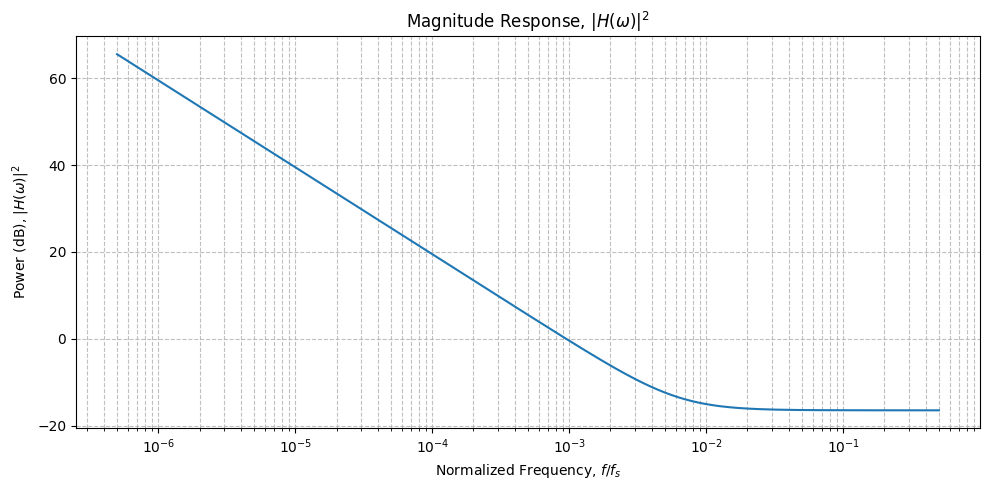

In [3]:
plt.figure(figsize=(10, 5))
sdr.plot.magnitude_response(loop_filter.iir, x_axis="log", decades=6)
plt.show()

## Implement a PLL in the phase domain

This section implements Example C.2.1 from *Digital Communications: A Discrete-Time Approach*.

In [4]:
N = 75  # samples
theta_0 = 2 * np.pi / 10  # radians/sample
x = theta_0 * np.arange(N) + np.pi  # Input phase signal, radians
y = np.zeros(x.size + 1)  # Output phase signal, radians
phase_error = np.zeros(x.size)  # Measured phase error, radians
freq_estimate = np.zeros(x.size)  # Estimated frequency, radians/sample

# Create a proportional-plus-integrator (PPI) loop filter with a normalized
# noise bandwidth of 0.05 and a damping factor of 1 (critically damped)
loop_filter = sdr.LoopFilter(0.05, 1)

# Create a numerically controlled oscillator (NCO) with NCO gain of 1,
# constant phase accumulation of theta_0 radians/sample, and initial phase
# offset of theta_0 radians.
nco = sdr.NCO(1, increment=theta_0, offset=theta_0)

for i in range(N):
    # Phase error detector (PED)
    phase_error[i] = x[i] - y[i]

    # Compute the frequency estimate
    freq_estimate[i] = loop_filter(phase_error[i])

    # Process the variable phase increment through the NCO
    y[i + 1] = nco(freq_estimate[i], output="phase")

/tmp/ipykernel_9468/3563252548.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  freq_estimate[i] = loop_filter(phase_error[i])


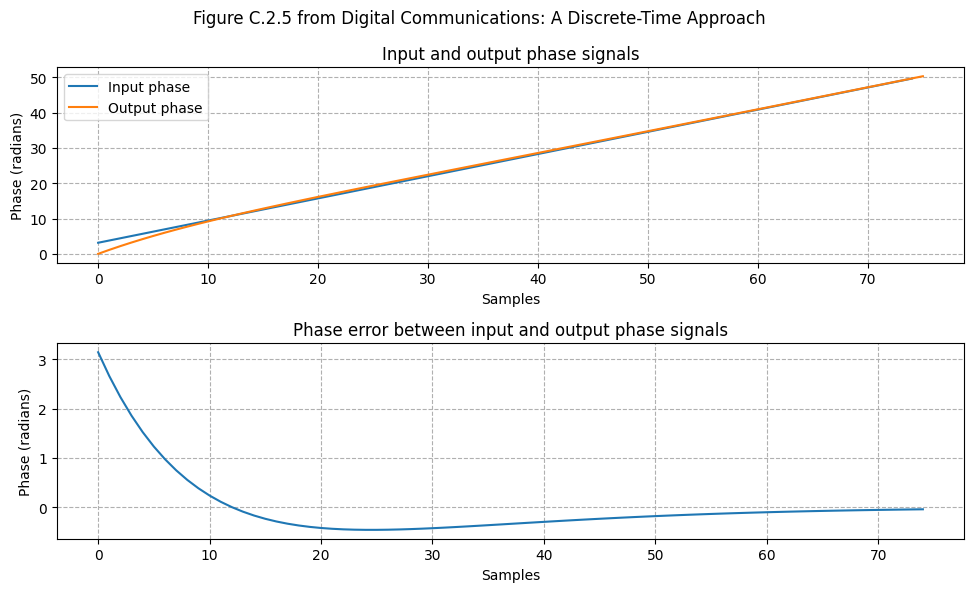

In [5]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sdr.plot.time_domain(x, label="Input phase")
sdr.plot.time_domain(y, label="Output phase")
plt.grid(which="both", linestyle="--")
plt.ylabel("Phase (radians)")
plt.title("Input and output phase signals")

plt.subplot(2, 1, 2)
sdr.plot.time_domain(phase_error)
plt.grid(which="both", linestyle="--")
plt.ylabel("Phase (radians)")
plt.title("Phase error between input and output phase signals")

plt.suptitle("Figure C.2.5 from Digital Communications: A Discrete-Time Approach")
plt.tight_layout()
plt.show()

## Implement a PLL in the time domain

This section implements Example C.2.1 from *Digital Communications: A Discrete-Time Approach*,
but using time-domain signals.

In [6]:
N = 75  # samples
theta_0 = 2 * np.pi / 10  # radians/sample
x = np.exp(1j * (theta_0 * np.arange(N) + np.pi))  # Input signal
y = np.ones(x.size + 1, dtype=complex)  # Output signal
phase_error = np.zeros(x.size)
freq_estimate = np.zeros(x.size)

# Create a numerically controlled oscillator (NCO) with NCO gain of 1,
# constant phase accumulation of theta_0 radians/sample, and initial phase
# offset of theta_0 radians.
nco = sdr.NCO(1, increment=theta_0, offset=theta_0)

# Create a heuristic phase error detector (PED).
ped = sdr.PED()

# Create a proportional-plus-integrator (PPI) loop filter with a normalized
# noise bandwidth of 0.05 and a damping factor of 1 (critically damped)
loop_filter = sdr.LoopFilter(0.05, 1, K0=nco.gain, Kp=ped.gain)

for i in range(N):
    # Heuristic phase error detector (PED)
    phase_error[i] = ped(x[i], y[i])

    # Compute the frequency estimate
    freq_estimate[i] = loop_filter(phase_error[i])

    # Process the variable phase increment through the DDS
    y[i + 1] = nco(freq_estimate[i])

/tmp/ipykernel_9468/2446258845.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  freq_estimate[i] = loop_filter(phase_error[i])


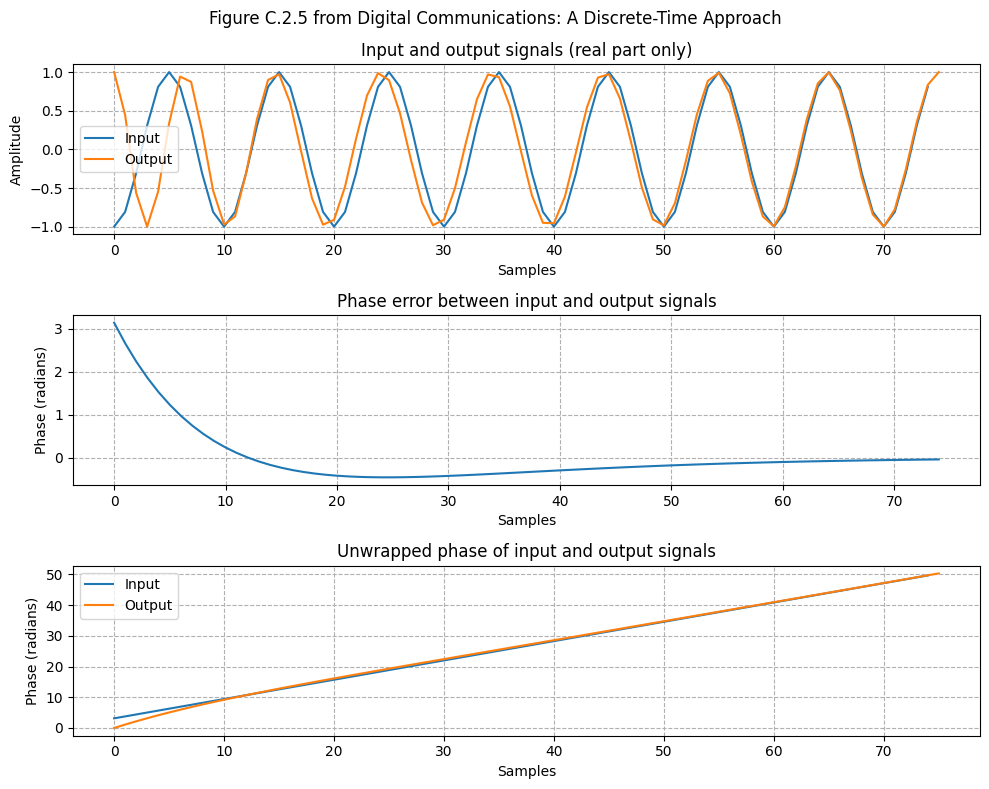

In [7]:
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
sdr.plot.time_domain(x.real, label="Input")
sdr.plot.time_domain(y.real, label="Output")
plt.grid(which="both", linestyle="--")
plt.ylabel("Amplitude")
plt.title("Input and output signals (real part only)")

plt.subplot(3, 1, 2)
sdr.plot.time_domain(phase_error)
plt.grid(which="both", linestyle="--")
plt.ylabel("Phase (radians)")
plt.title("Phase error between input and output signals")

plt.subplot(3, 1, 3)
sdr.plot.time_domain(np.unwrap(np.angle(x)), label="Input")
sdr.plot.time_domain(np.unwrap(np.angle(y)), label="Output")
plt.grid(which="both", linestyle="--")
plt.ylabel("Phase (radians)")
plt.title("Unwrapped phase of input and output signals")

plt.suptitle("Figure C.2.5 from Digital Communications: A Discrete-Time Approach")
plt.tight_layout()
plt.show()

This section implements Example 7.2.3 from *Digital Communications: A Discrete-Time Approach*.

In [8]:
N = 250  # symbols
qpsk = sdr.PSK(4, phase_offset=45)
a = qpsk.map_symbols(np.random.randint(0, 4, N))  # QPSK complex symbols
a *= np.exp(1j * np.pi / 4)  # Rotate symbols by pi/4 radians
lo = np.ones(a.size + 1, dtype=complex)  # Local oscillator
a_tilde = np.ones(a.size + 1, dtype=complex)  # De-rotated symbols

phase_error = np.zeros(a.size)
freq_estimate = np.zeros(a.size)

# Create a numerically controlled oscillator (NCO) with NCO gain of 1.
nco = sdr.NCO(1)

# Create a maximum-likelihood phase error detector (ML-PED).
ped = sdr.MLPED()

# Create a proportional-plus-integrator (PPI) loop filter with a normalized
# noise bandwidth of 0.05 and a damping factor of 1 (critically damped)
loop_filter = sdr.LoopFilter(0.02, 1 / np.sqrt(2), K0=nco.gain, Kp=ped.gain)

for i in range(N):
    # De-rotate the input symbols
    a_tilde[i] = a[i] * lo[i].conj()

    # Make a symbol decision
    s_hat, a_hat = qpsk.decide_symbols(a_tilde[i])

    # Maximum-likelihood phase error detector (ML-PED)
    phase_error[i] = ped(a_tilde[i], a_hat)

    # Compute the frequency estimate
    freq_estimate[i] = loop_filter(phase_error[i])

    # Process the variable phase increment through the DDS
    lo[i + 1] = nco(freq_estimate[i])

/tmp/ipykernel_9468/2528482220.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  freq_estimate[i] = loop_filter(phase_error[i])


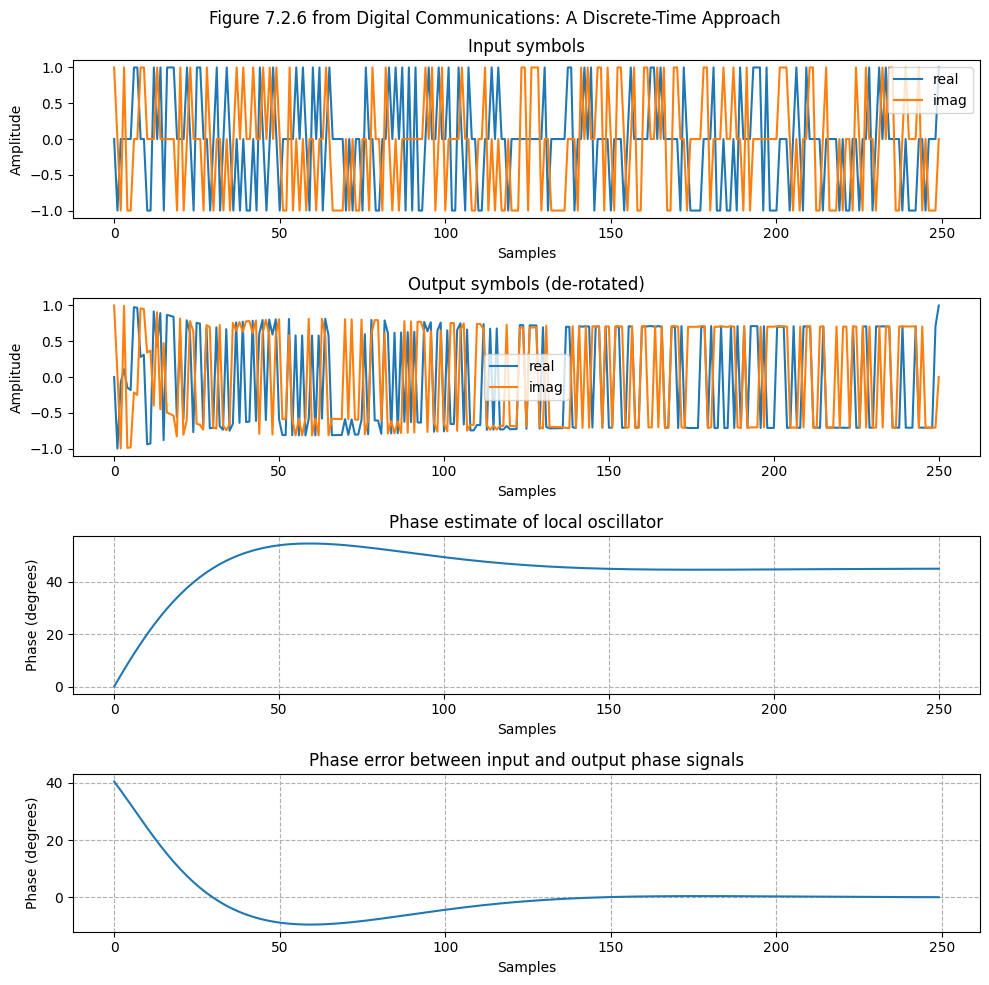

In [9]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
sdr.plot.time_domain(a)
plt.title("Input symbols")

plt.subplot(4, 1, 2)
sdr.plot.time_domain(a_tilde)
plt.title("Output symbols (de-rotated)")

plt.subplot(4, 1, 3)
sdr.plot.time_domain(np.angle(lo, deg=True))
plt.grid(which="both", linestyle="--")
plt.ylabel("Phase (degrees)")
plt.title("Phase estimate of local oscillator")

plt.subplot(4, 1, 4)
sdr.plot.time_domain(np.rad2deg(phase_error))
plt.grid(which="both", linestyle="--")
plt.ylabel("Phase (degrees)")
plt.title("Phase error between input and output phase signals")

plt.suptitle("Figure 7.2.6 from Digital Communications: A Discrete-Time Approach")
plt.tight_layout()
plt.show()

## Analyze PLL closed-loop performance

A closed-loop PLL has the following configuration.

```text
            bb[n]    phase_err[n]
        +---+    +-----+    +----+
x[n] -->| X |--->| PED |--->| LF |---+
        +---+    +-----+    +----+   |
          ^                          | phase_est[n]
          |      +-----+             |
   lo[n]  +------| NCO |<------------+
                 +-----+


x[n] = Input signal
lo[n] = Local oscillator signal
bb[n] = Baseband signal
PED = Phase error detector
LF = Loop filter
NCO = Numerically-controlled oscillator
```

The closed-loop transfer function of the PLL is

$$
H_{PLL}(z) = \frac{K_p K_0 (K_1 + K_2) z^{-1} - K_p K_0 K_1 z^{-2}}
{1 - 2 (1 - \frac{1}{2} K_p K_0 (K_1 + K_2) z^{-1} + (1 - K_p K_0 K_1) z^{-2} } .
$$

The analysis of the performance of this closed-loop system is available in {obj}`sdr.ClosedLoopPLL`.

### Compare step and frequency response across $\zeta$

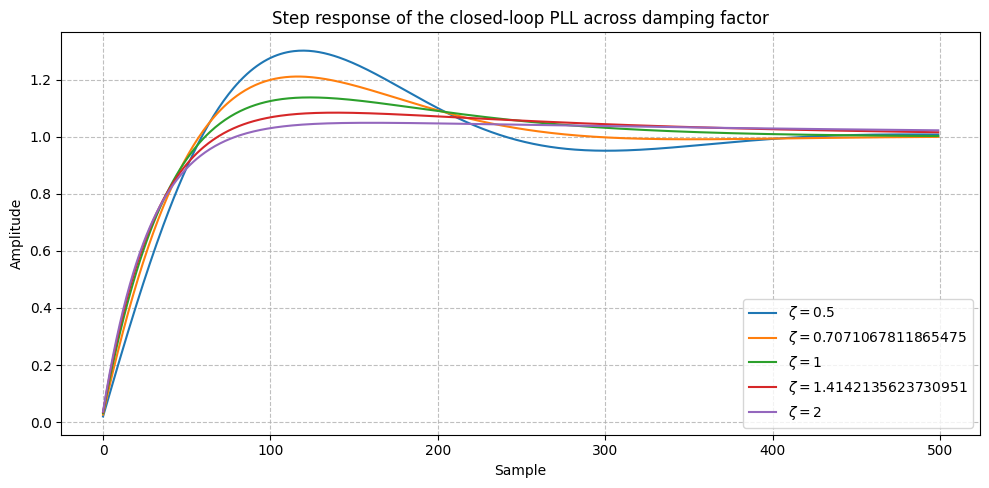

In [10]:
plt.figure(figsize=(10, 5))
for zeta in [1 / 2, 1 / np.sqrt(2), 1, np.sqrt(2), 2]:
    pll = sdr.ClosedLoopPLL(0.01, zeta)
    sdr.plot.step_response(pll.iir, N=500, label=rf"$\zeta = {zeta}$")
plt.title("Step response of the closed-loop PLL across damping factor")
plt.show()

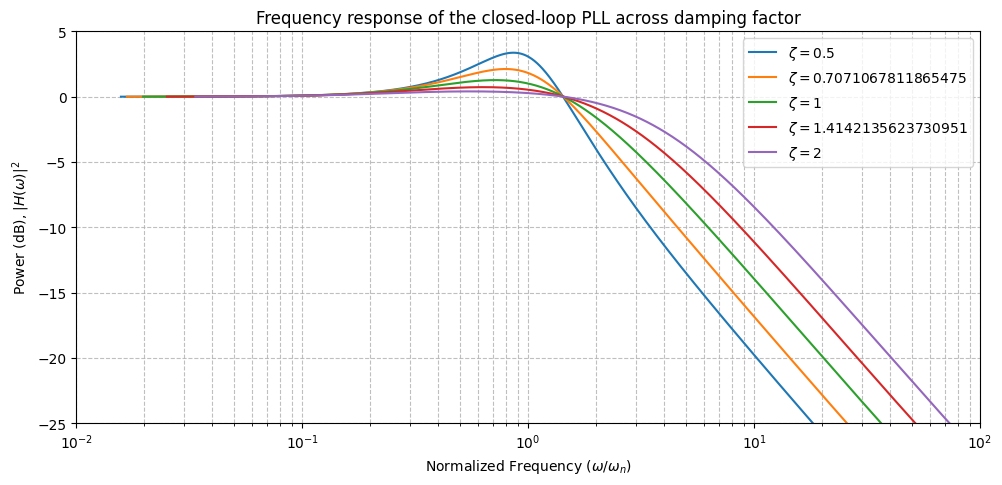

In [11]:
plt.figure(figsize=(10, 5))
for zeta in [1 / 2, 1 / np.sqrt(2), 1, np.sqrt(2), 2]:
    pll = sdr.ClosedLoopPLL(0.01, zeta)
    sdr.plot.magnitude_response(pll.iir, sample_rate=2 * np.pi / pll.omega_n, x_axis="log", label=rf"$\zeta = {zeta}$")
plt.xlim([10**-2, 10**2])
plt.ylim([-25, 5])
plt.xlabel(r"Normalized Frequency ($\omega / \omega_n$)")
plt.title("Frequency response of the closed-loop PLL across damping factor")
plt.show()

### Compare step and frequency response across $B_n T$

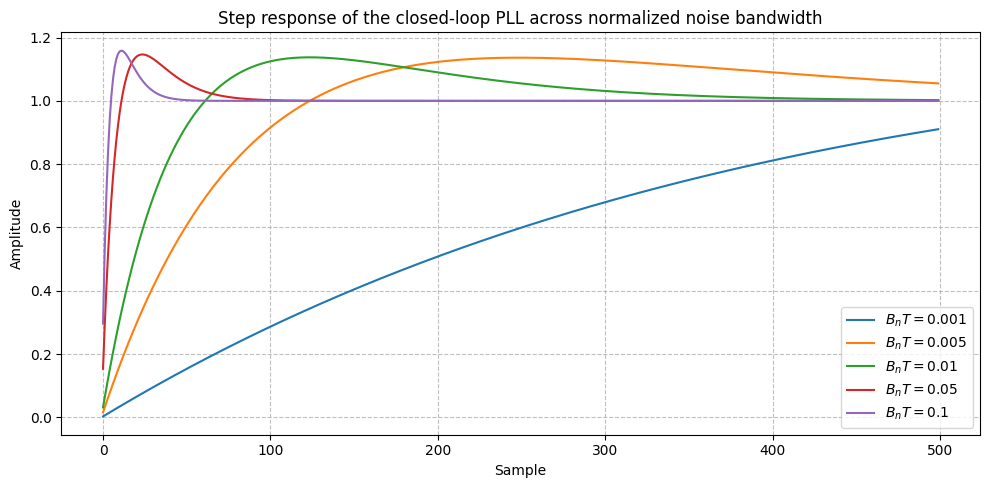

In [12]:
plt.figure(figsize=(10, 5))
for BnT in [0.001, 0.005, 0.01, 0.05, 0.1]:
    pll = sdr.ClosedLoopPLL(BnT, 1)
    sdr.plot.step_response(pll.iir, N=500, label=f"$B_nT = {BnT}$")
plt.title("Step response of the closed-loop PLL across normalized noise bandwidth")
plt.show()

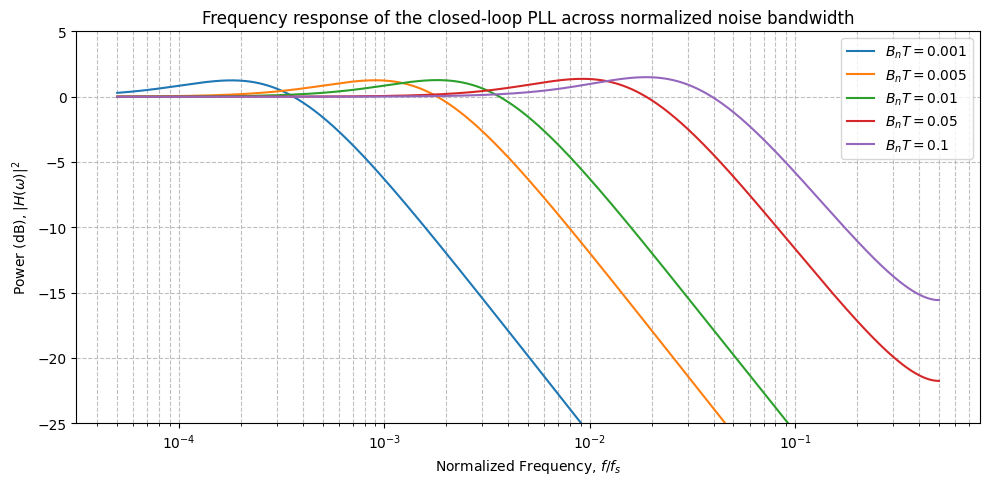

In [13]:
plt.figure(figsize=(10, 5))
for BnT in [0.001, 0.005, 0.01, 0.05, 0.1]:
    pll = sdr.ClosedLoopPLL(BnT, 1)
    sdr.plot.magnitude_response(pll.iir, x_axis="log", label=f"$B_nT = {BnT}$")
plt.ylim([-25, 5])
plt.title("Frequency response of the closed-loop PLL across normalized noise bandwidth")
plt.show()

### Compare lock time across $B_n T$

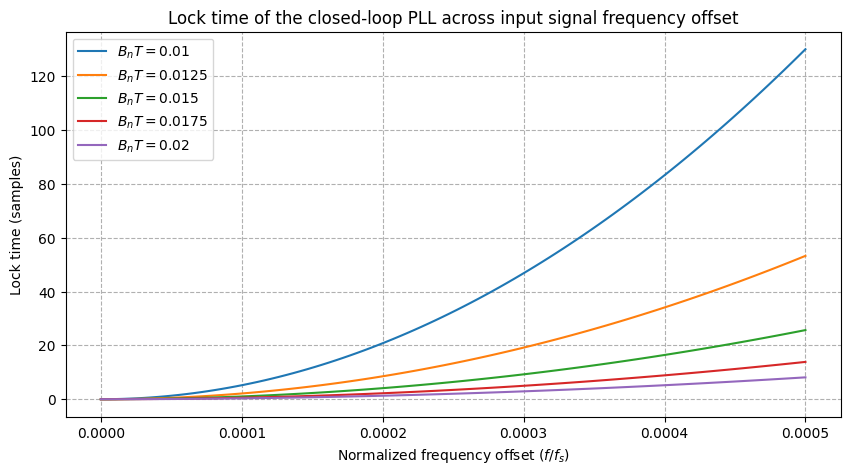

In [14]:
freq = np.linspace(0, 0.0005, 100)

plt.figure(figsize=(10, 5))
for BnT in [0.01, 0.0125, 0.015, 0.0175, 0.02]:
    pll = sdr.ClosedLoopPLL(BnT, 1)
    t_lock = pll.lock_time(freq)
    plt.plot(freq, t_lock, label=f"$B_nT = {BnT}$")
plt.grid(which="both", linestyle="--")
plt.legend()
plt.xlabel("Normalized frequency offset ($f / f_s$)")
plt.ylabel("Lock time (samples)")
plt.title("Lock time of the closed-loop PLL across input signal frequency offset")
plt.show()